In [78]:
import tellurium as te
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix.ant'

In [79]:
q_cols = {'1':'QVen', '2':'QArt', '3':'QFat', '4':'QPoor', '5':'QRich', '6':'QLiver',
                          '7':'QSkin_u', '8':'QSkin_e', '9':'QSkin_sc_u', '10':'QSkin_sc_e',
                          '11':'QGut', '12':'QExcret', '13':'QMetab'}

def get_r_results(fn):
    r_out = pd.read_csv(f'../validation/R/results//{fn}').drop(columns=['Unnamed: 0'])
    r_out.rename(columns=q_cols, inplace=True)
    r_out['QTotal'] = r_out.drop(columns=['time', 'CTotal']).sum(axis=1)
    long_r = pd.melt(r_out[['time']+list(q_cols.values())+['QTotal']], id_vars=['time'],
                     value_vars=list(q_cols.values())+['QTotal'],
                     var_name='quantity', value_name='value')
    long_r['src'] = 'R'
    return long_r

def get_ant_results(results, outputs):
    df = pd.DataFrame(results, columns=outputs)
    df["QTotal"] = df.iloc[:, 1:].sum(axis=1)
    df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    df['src'] = 'ant'
    return df


In [80]:
def compare(results, outputs, fn_r):
    """Compare results obtained with R implementation to results of Antimony implementation."""
    long_ant = get_ant_results(results, outputs)
    long_r = get_r_results(fn_r)
    all_df = pd.concat((long_ant, long_r))
    g = sns.FacetGrid(
        all_df,
        col='quantity',
        hue='src',
        col_wrap = 5,
        sharey = False,
        col_order=list(q_cols.values())+['QTotal'])
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()


# Mass action kinetics

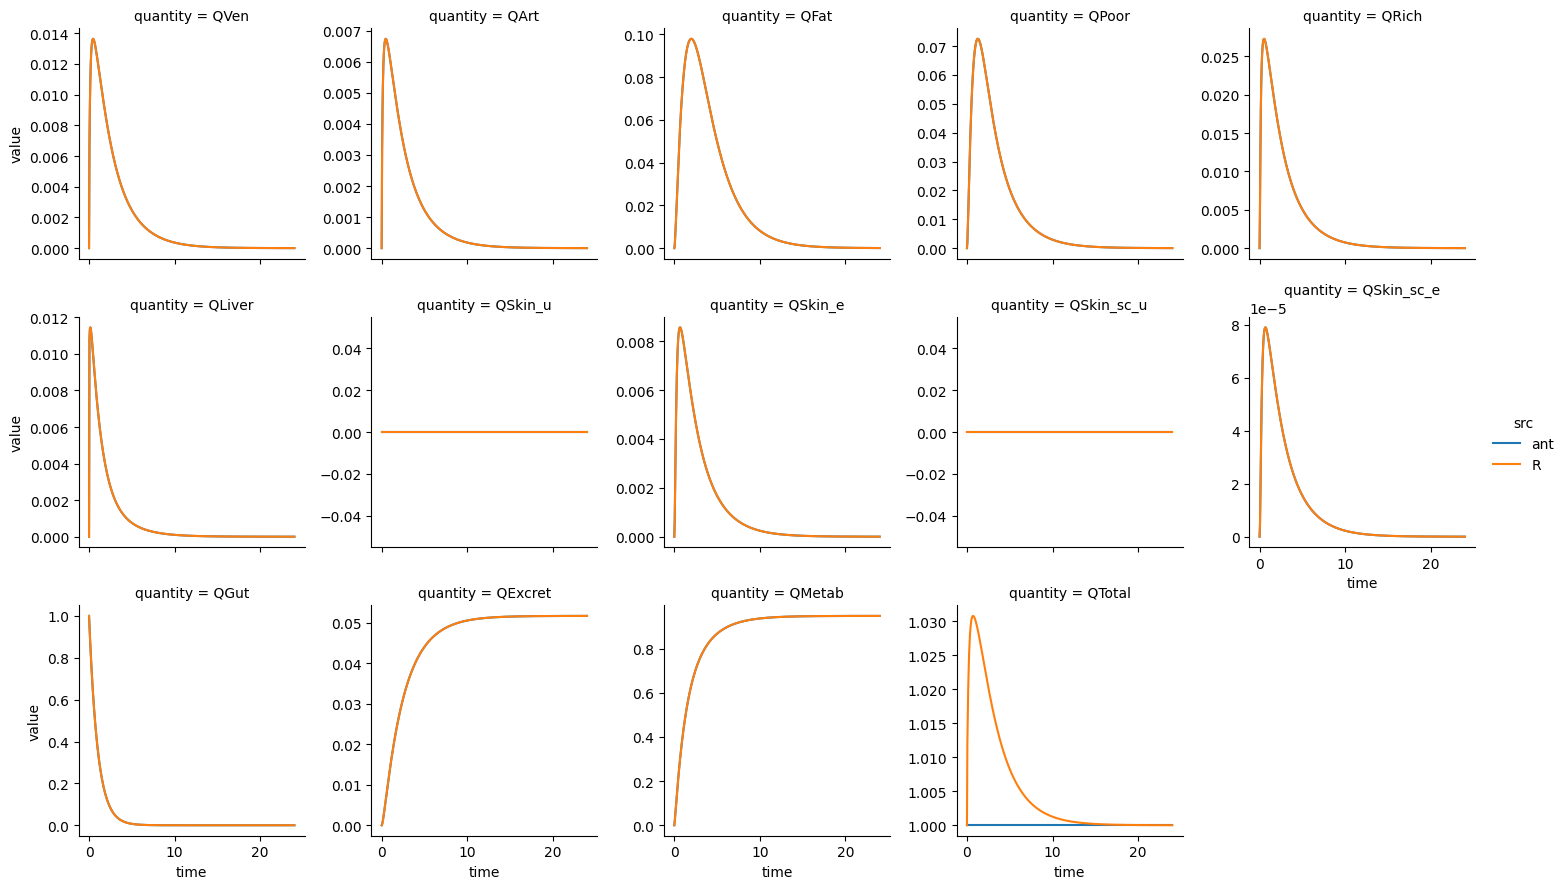

In [ ]:
# Load model with fSA_exposed = 0.1
rr_model = te.loada(fn_ant)

# Set output to amounts
amount_ids = [sid for sid in rr_model.getFloatingSpeciesIds()]
rr_model.timeCourseSelections = ['time'] + amount_ids

# Set simulation parameters
rr_model.fSA_exposed = 1
rr_model.QGut = 1

# Simulate
results = rr_model.simulate(0, 24, 500)

# Compare results
compare(
    results,
    rr_model.timeCourseSelections,
    fn_r='euromix_r_results_MA.csv'
)

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the roadrunner simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.

# Michaelis menten kinetics

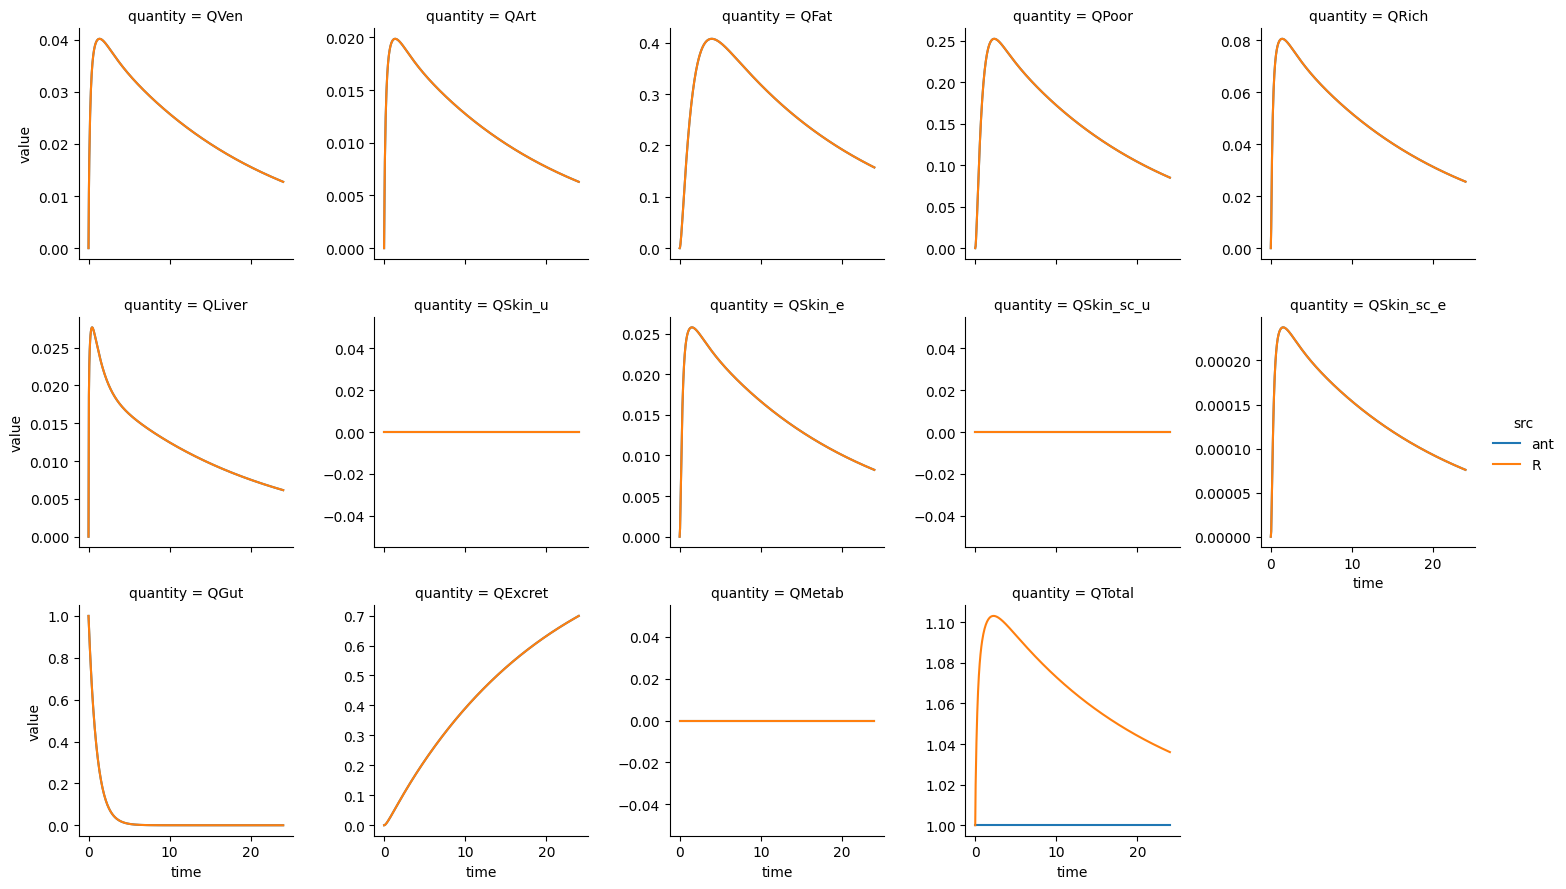

In [82]:
# Load model with fSA_exposed = 0.1
rr_model = te.loada(fn_ant)

# Set output to amounts
amount_ids = [sid for sid in rr_model.getFloatingSpeciesIds()]
rr_model.timeCourseSelections = ['time'] + amount_ids

# Set simulation parameters
rr_model.QGut = 1
rr_model.Michaelis = 1
rr_model.Km = 1
rr_model.fSA_exposed = 1

# Simulate
results = rr_model.simulate(0, 24, 500)

# Compare results
compare(
    results,
    rr_model.timeCourseSelections,
    fn_r='euromix_r_results_MM.csv'
)

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the Antimony simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.